Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /root/.cache/torch/hub/rwightman_gen-efficientnet-pytorch_master


Loading weights:  None


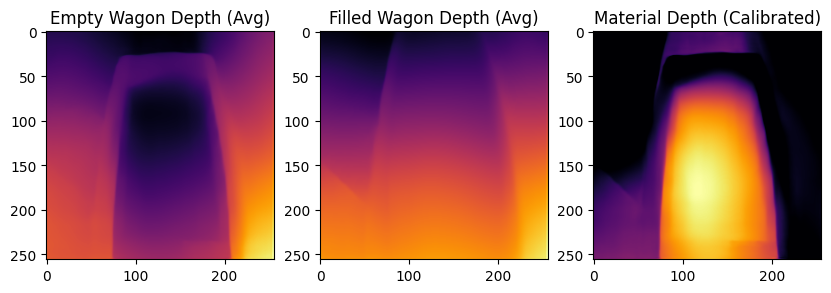

Estimated volume of stored clinker: 45.17 cubic meters
Estimated weight of stored clinker: 60.98 tons


In [ ]:
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from torchvision.transforms import Compose, ToTensor, Normalize

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
midas = torch.hub.load("intel-isl/MiDaS", "MiDaS_small").to(device)
midas.eval()

if torch.__version__ >= "2.0":
    midas = torch.compile(midas)

def preprocess(frame, size=(256, 256)):
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frame = cv2.resize(frame, size)
    transform = Compose([ToTensor(), Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
    return transform(frame).unsqueeze(0).to(device)

def process_video(video_path, frame_skip=5, save_path=None):
    if not os.path.exists(video_path):
        raise FileNotFoundError(f"File not found: {video_path}")

    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        raise ValueError(f"Could not open video: {video_path}")

    depth_maps = []
    frame_count = 0

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        if frame_count % frame_skip == 0:
            img_tensor = preprocess(frame)
            with torch.no_grad():
                depth_map = midas(img_tensor).squeeze().cpu().numpy()
            depth_maps.append(depth_map)

        frame_count += 1

    cap.release()

    if len(depth_maps) == 0:
        raise ValueError("No frames processed. Video might be empty or corrupted.")

    avg_depth_map = np.mean(depth_maps, axis=0)

    if save_path:
        np.save(save_path, avg_depth_map)

    return avg_depth_map

empty_wagon_path = '/content/sample_data/2.mp4'
filled_wagon_path = '/content/sample_data/5.mp4'

empty_depth_file = "empty_wagon_depth.npy"
filled_depth_file = "filled_wagon_depth.npy"

if os.path.exists(empty_depth_file) and os.path.exists(filled_depth_file):
    empty_wagon_depth = np.load(empty_depth_file)
    filled_wagon_depth = np.load(filled_depth_file)
else:
    empty_wagon_depth = process_video(empty_wagon_path, save_path=empty_depth_file)
    filled_wagon_depth = process_video(filled_wagon_path, save_path=filled_depth_file)

if empty_wagon_depth.size == 0 or filled_wagon_depth.size == 0:
    raise ValueError("Depth maps are empty. Check video processing.")

depth_difference = np.maximum(filled_wagon_depth - empty_wagon_depth, 0)

wagon_length = 9
wagon_width = 3.18
wagon_height = 3.243

if len(empty_wagon_depth.shape) < 2:
    raise ValueError("Invalid depth map dimensions. Expected 2D array.")

pixels_per_meter = empty_wagon_depth.shape[1] / wagon_width
real_depth_difference = depth_difference / pixels_per_meter

wagon_volume_m3 = np.sum(real_depth_difference) * (wagon_width / empty_wagon_depth.shape[1]) * (wagon_length / empty_wagon_depth.shape[0])

clinker_density = 1350
wagon_mass_tons = (wagon_volume_m3 * clinker_density) / 1000

plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.imshow(empty_wagon_depth, cmap="inferno")
plt.title("Empty Wagon Depth (Avg)")
plt.subplot(1, 3, 2)
plt.imshow(filled_wagon_depth, cmap="inferno")
plt.title("Filled Wagon Depth (Avg)")
plt.subplot(1, 3, 3)
plt.imshow(real_depth_difference, cmap="inferno")
plt.title("Material Depth (Calibrated)")
plt.show()

print(f"Estimated volume of stored clinker: {wagon_volume_m3:.2f} cubic meters")
print(f"Estimated weight of stored clinker: {wagon_mass_tons:.2f} tons")


In [ ]:
from reportlab.lib.pagesizes import letter
from reportlab.pdfgen import canvas
from reportlab.lib.utils import ImageReader
import matplotlib.pyplot as plt
import numpy as np
import cv2

# Define output PDF file
pdf_filename = "clinker_report.pdf"

def save_plot(image, title, filename):
    plt.figure(figsize=(5, 5))
    plt.imshow(image, cmap="inferno")
    plt.title(title)
    plt.axis("off")
    plt.savefig(filename, bbox_inches='tight')
    plt.close()

# Save images for the report
empty_wagon_img = "empty_wagon_depth.png"
filled_wagon_img = "filled_wagon_depth.png"
material_depth_img = "material_depth.png"

save_plot(empty_wagon_depth, "Empty Wagon Depth (Avg)", empty_wagon_img)
save_plot(filled_wagon_depth, "Filled Wagon Depth (Avg)", filled_wagon_img)
save_plot(real_depth_difference, "Material Depth (Calibrated)", material_depth_img)

def generate_pdf_report(filename, wagon_number, volume, weight, material_name, img1, img2):
    c = canvas.Canvas(filename, pagesize=letter)
    width, height = letter

    c.setFont("Helvetica-Bold", 16)
    c.drawString(200, 750, "Clinker Load Report")
    c.setFont("Helvetica", 12)

    # Report details
    c.drawString(100, 700, f"Wagon Number: {wagon_number}")
    c.drawString(100, 680, f"Material: {material_name}")
    c.drawString(100, 660, f"Estimated Volume: {volume:.2f} cubic meters")
    c.drawString(100, 640, f"Estimated Weight: {weight:.2f} tons")

    # Add images
    c.drawImage(ImageReader(img1), 100, 400, width=200, height=200)
    c.drawImage(ImageReader(img2), 300, 400, width=200, height=200)

    c.save()

# Call function to generate report
generate_pdf_report(pdf_filename, "WGN-12345", wagon_volume_m3, wagon_mass_tons, "Clinker", empty_wagon_img, material_depth_img)

print(f"PDF report generated: {pdf_filename}")


PDF report generated: clinker_report.pdf
